<style>
.text_cell_render {
font-family: Times New Roman, serif;
}
</style>

#![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)

# **Word Count Lab: Building a word count application**
###  The volume of unstructured text in existence is growing dramatically, and Spark is an excellent tool for analyzing this type of data.  In this lab, we will write code that calculates the most common words in the [Complete Works of William Shakespeare](http://www.gutenberg.org/ebooks/100) retrieved from [Project Gutenberg](http://www.gutenberg.org/wiki/Main_Page).  This could also be scaled to find the most common words on the Internet.
### ** During this lab we will cover: **
### *Part 1:* Creating a base RDD and pair RDDs
### *Part 2:* Counting with pair RDDs
### *Part 3:* Finding unique words and a mean value
### *Part 4:* Apply word count to a file
### Note that, for reference, you can look up the details of the relevant methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD)

## ** Part 1: Creating a base RDD and pair RDDs **

### In this part of the lab, we will explore creating a base RDD with `parallelize` and using pair RDDs to count words.

### ** (1a) Create a base RDD **
### We'll start by generating a base RDD by using a Python list and the `sc.parallelize` method.  Then we'll print out the type of the base RDD.

In [132]:
sc

In [1]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
# Print out the type of wordsRDD
print type(wordsRDD)

<class 'pyspark.rdd.RDD'>


### (1b) Pluralize and test

### Let's use a `map()` transformation to add the letter 's' to each string in the base RDD we just created. We'll define a Python function that returns the word with an 's' at the end of the word.

In [2]:
def makePlural(word):
    """Adds an 's' to `word`.

    Note:
        This is a simple function that only adds an 's'.  No attempt is made to follow proper
        pluralization rules.

    Args:
        word (str): A string.

    Returns:
        str: A string with 's' added to it.
    """
    return word+'s'

print makePlural('cat')

cats


In [3]:
# One way of completing the function
def makePlural(word):
    return word + 's'

print makePlural('cat')

cats


### ** (1c) Apply `makePlural` to the base RDD **
### Now pass each item in the base RDD into a [map()](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.map) transformation that applies the `makePlural()` function to each element. And then call the [collect()](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collect) action to see the transformed RDD.

In [4]:
pluralRDD = wordsRDD.map(makePlural)
print pluralRDD.collect()

['cats', 'elephants', 'rats', 'rats', 'cats']


### ** (1d) Pass a `lambda` function to `map` **
### Let's create the same RDD using a `lambda` function.

In [5]:
pluralLambdaRDD = wordsRDD.map(lambda x: x+'s')
print pluralLambdaRDD.collect()

['cats', 'elephants', 'rats', 'rats', 'cats']


### ** (1e) Length of each word **
### Now use `map()` and a `lambda` function to return the number of characters in each word.  We'll `collect` this result directly into a variable.

In [7]:
pluralLengths = (pluralRDD
                 .map(lambda word: len(word))
                 .collect())
print pluralLengths

[4, 9, 4, 4, 4]


### ** (1f) Pair RDDs **
### The next step in writing our word counting program is to create a new type of RDD, called a pair RDD. A pair RDD is an RDD where each element is a pair tuple `(k, v)` where `k` is the key and `v` is the value. In this example, we will create a pair consisting of `('<word>', 1)` for each word element in the RDD.
#### We can create the pair RDD using the `map()` transformation with a `lambda()` function to create a new RDD.

In [8]:
wordPairs = wordsRDD.map(lambda word: (word,1))
print wordPairs.collect()

[('cat', 1), ('elephant', 1), ('rat', 1), ('rat', 1), ('cat', 1)]


### ** Part 2: Counting with pair RDDs **

### Now, let's count the number of times a particular word appears in the RDD. There are multiple ways to perform the counting, but some are much less efficient than others.

### A naive approach would be to `collect()` all of the elements and count them in the driver program. While this approach could work for small datasets, we want an approach that will work for any size dataset including terabyte- or petabyte-sized datasets. In addition, performing all of the work in the driver program is slower than performing it in parallel in the workers. For these reasons, we will use data parallel operations.

### ** (2a) `groupByKey()` approach **
### An approach you might first consider (we'll see shortly that there are better ways) is based on using the [groupByKey()](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.groupByKey) transformation. As the name implies, the `groupByKey()` transformation groups all the elements of the RDD with the same key into a single list in one of the partitions. There are two problems with using `groupByKey()`:
  + ### The operation requires a lot of data movement to move all the values into the appropriate partitions.
  + ### The lists can be very large. Consider a word count of English Wikipedia: the lists for common words (e.g., the, a, etc.) would be huge and could exhaust the available memory in a worker.
 
### Use `groupByKey()` to generate a pair RDD of type `('word', iterator)`.

In [9]:
# Note that groupByKey requires no parameters
wordsGrouped = wordPairs.groupByKey()
wordsGrouped

PythonRDD[9] at RDD at PythonRDD.scala:42

In [146]:
for key, value in wordsGrouped.collect():
    print '{0}: {1}'.format(key, list(value))

rat: [1, 1]
elephant: [1]
cat: [1, 1]


### ** (2b) Use `groupByKey()` to obtain the counts **
#### Using the `groupByKey()` transformation creates an RDD containing 3 elements, each of which is a pair of a word and a Python iterator.
#### Now sum the iterator using a `map()` transformation.  The result should be a pair RDD consisting of (word, count) pairs.

In [151]:
wordCountsGrouped = wordsGrouped.map(lambda (k,v): (k,sum(v)))
print wordCountsGrouped.collect()

[('rat', 2), ('cat', 2), ('elephant', 1)]


### ** (2c) Counting using `reduceByKey` **
### A better approach is to start from the pair RDD and then use the [reduceByKey()](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey) transformation to create a new pair RDD. The `reduceByKey()` transformation gathers together pairs that have the same key and applies the function provided to two values at a time, iteratively reducing all of the values to a single value. `reduceByKey()` operates by applying the function first within each partition on a per-key basis and then across the partitions, allowing it to scale efficiently to large datasets.

### The function should be commutative and associative so that it can be computed correctly in parallel.

In [154]:
# Note that reduceByKey takes in a function that accepts two values and returns a single value
wordCounts = wordPairs.reduceByKey(lambda v1,v2:v1+v2)
print wordCounts.collect()

[('rat', 2), ('cat', 2), ('elephant', 1)]


### ** (2d) All together **
### The expert version of the code performs the `map()` to pair RDD, `reduceByKey()` transformation, and `collect` in one statement.

In [11]:
wordCountsCollected = wordsRDD.map(lambda x: (x,1)).reduceByKey(lambda v1,v2:v1+v2).collect()
print wordCountsCollected

[('rat', 2), ('elephant', 1), ('cat', 2)]


### ** Part 3: Finding unique words and a mean value **

### ** (3a) Unique words **
### Calculate the number of unique words in `wordsRDD`.  You can use other RDDs that you have already created to make this easier.

In [157]:
uniqueWords = wordCounts.count()
print uniqueWords

3


### ** (3b) Mean using `reduce` **
### Find the mean number of words per unique word in `wordCounts`.
### Use a `reduce()` action to sum the counts in `wordCounts` and then divide by the number of unique words.  First `map()` the pair RDD `wordCounts`, which consists of (key, value) pairs, to an RDD of values.

In [162]:
from operator import add
totalCount = (wordCounts
              .map(lambda (k,v):v)
              .reduce(lambda v1,v2:v1+v2)
             )
average = totalCount / float(uniqueWords)
print totalCount
print round(average, 2)

5
1.67


### ** Part 4: Apply word count to a file **

### In this section we will finish developing our word count application.  We'll have to build the `wordCount` function, deal with real world problems like capitalization and punctuation, load in our data source, and compute the word count on the new data.

### ** (4a) `wordCount` function **
### First, define a function for word counting.  You should reuse the techniques that have been covered in earlier parts of this lab.  This function should take in an RDD that is a list of words like `wordsRDD` and return a pair RDD that has all of the words and their associated counts.

In [12]:
def wordCount(wordListRDD):
    """Creates a pair RDD with word counts from an RDD of words.

    Args:
        wordListRDD (RDD of str): An RDD consisting of words.

    Returns:
        RDD of (str, int): An RDD consisting of (word, count) tuples.
    """
    return (wordListRDD
            .map(lambda word: (word,1))
            .reduceByKey(lambda v1,v2: v1+v2)
           )
    
print wordCount(wordsRDD).collect()

[('rat', 2), ('cat', 2), ('elephant', 1)]


### ** (4b) Capitalization and punctuation **
### Real world files are more complicated than the data we have been using in this lab. Some of the issues we have to address are:
  + #### Words should be counted independent of their capitialization (e.g., Spark and spark should be counted as the same word).
  + #### All punctuation should be removed.
  + #### Any leading or trailing spaces on a line should be removed.
 
### Define the function `removePunctuation` that converts all text to lower case, removes any punctuation, and removes leading and trailing spaces.  Use the Python [re](https://docs.python.org/2/library/re.html) module to remove any text that is not a letter, number, or space. Reading `help(re.sub)` might be useful.

In [13]:
import re
def removePunctuation(text):
    """Removes punctuation, changes to lower case, and strips leading and trailing spaces.

    Note:
        Only spaces, letters, and numbers should be retained.  Other characters should should be
        eliminated (e.g. it's becomes its).  Leading and trailing spaces should be removed after
        punctuation is removed.

    Args:
        text (str): A string.

    Returns:
        str: The cleaned up string.
    """
    return ('').join(re.findall(r'[^\'?:._!,\(\)\[\];\"-\--\/\}\{]+',text.lower().strip()))

print removePunctuation('Hi, you!')
print removePunctuation(' No under_score!')

hi you
no underscore


### ** (4c) Load a text file **
### For the next part of this lab, we will use the [Complete Works of William Shakespeare](http://www.gutenberg.org/ebooks/100) from [Project Gutenberg](http://www.gutenberg.org/wiki/Main_Page). To convert a text file into an RDD, we use the `SparkContext.textFile()` method. We also apply the recently defined `removePunctuation()` function using a `map()` transformation to strip out the punctuation and change all text to lowercase.  Since the file is large we use `take(15)`, so that we only print 15 lines.

In [14]:
# Just run this code
import os.path
baseDir = os.path.join('data')
inputPath = os.path.join('shakespeare.txt')
fileName = os.path.join(baseDir, inputPath)

shakespeareRDD = (sc
                  .textFile(fileName, 8)
                  .map(removePunctuation))
print '\n'.join(shakespeareRDD
                .zipWithIndex()  # to (line, lineNum)
                .map(lambda (l, num): '{0}: {1}'.format(num, l))  # to 'lineNum: line'
                .take(15))


0: 1609
1: 
2: the sonnets
3: 
4: by william shakespeare
5: 
6: 
7: 
8: 1
9: from fairest creatures we desire increase
10: that thereby beautys rose might never die
11: but as the riper should by time decease
12: his tender heir might bear his memory
13: but thou contracted to thine own bright eyes
14: feedst thy lights flame with selfsubstantial fuel


### ** (4d) Words from lines **
### Before we can use the `wordcount()` function, we have to address two issues with the format of the RDD:
  + ### The first issue is that  that we need to split each line by its spaces.
  + ### The second issue is we need to filter out empty lines.
 
### Apply a transformation that will split each element of the RDD by its spaces. For each element of the RDD, you should apply Python's string [split()](https://docs.python.org/2/library/string.html#string.split) function. You might think that a `map()` transformation is the way to do this, but think about what the result of the `split()` function will be.

In [169]:
shakespeareWordsRDD = shakespeareRDD.flatMap(lambda line: line.split(' '))
shakespeareWordCount = shakespeareWordsRDD.count()
print shakespeareWordsRDD.top(5)
print shakespeareWordCount

[u'zwaggerd', u'zounds', u'zounds', u'zounds', u'zounds']
928908


### ** (4e) Remove empty elements **
### The next step is to filter out the empty elements.  Remove all entries where the word is `''`.

In [170]:
shakeWordsRDD = shakespeareWordsRDD.filter(lambda word: word != '')
shakeWordCount = shakeWordsRDD.count()
print shakeWordCount

882996


#### ** (4f) Count the words **
#### We now have an RDD that is only words.  Next, let's apply the `wordCount()` function to produce a list of word counts. We can view the top 15 words by using the `takeOrdered()` action; however, since the elements of the RDD are pairs, we need a custom sort function that sorts using the value part of the pair.
#### You'll notice that many of the words are common English words. These are called stopwords. In a later lab, we will see how to eliminate them from the results.
#### Use the `wordCount()` function and `takeOrdered()` to obtain the fifteen most common words and their counts.

In [172]:
top15WordsAndCounts = (shakeWordsRDD
                       .map(lambda word: (word,1))
                       .reduceByKey(lambda v1,v2: v1+v2)
                       .takeOrdered(15,key = lambda (k,v):(-v,k)))
print '\n'.join(map(lambda (w, c): '{0}: {1}'.format(w, c), top15WordsAndCounts))

the: 27361
and: 26028
i: 20681
to: 19150
of: 17463
a: 14593
you: 13615
my: 12481
in: 10956
that: 10890
is: 9134
not: 8497
with: 7771
me: 7769
it: 7678


![ML Logo](http://spark-mooc.github.io/web-assets/images/CS190.1x_Banner_300.png)
# **Math and Python review**
### This notebook reviews vector and matrix math, the [NumPy](http://www.numpy.org/) Python package. Part 1 covers vector and matrix math, and we'll do the exercises by hand.  In Part 2, we'll learn about NumPy and use `ndarray` objects to solve the math exercises.   Part 3 provides additional information about NumPy and how it relates to array usage in Spark's [MLlib](https://spark.apache.org/mllib/).  


 
### ** This notebook covers: **
### *Part 1:* Math review
### *Part 2:* NumPy
### *Part 3:* Additional NumPy and Spark linear algebra

## ** Part 1: Math review **

### ** (1a) Scalar multiplication: vectors **
### In this exercise, you will calculate the product of a scalar and a vector by hand and enter the result in the code cell below.  Scalar multiplication is straightforward.  The resulting vector equals the product of the scalar, which is a single value, and each item in the original vector.  In the example below, $ a $ is the scalar (constant) and $ \mathbf{v} $ is the vector.  $$ a \mathbf{v} = \begin{bmatrix} a v_1 \\\ a v_2 \\\ \vdots \\\ a v_n \end{bmatrix} $$
### Calculate the value of $ \mathbf{x} $: $$ \mathbf{x} = 3 \begin{bmatrix} 1 \\\ -2 \\\ 0 \end{bmatrix} $$
### Calculate the value of $ \mathbf{y} $: $$ \mathbf{y} = 2 \begin{bmatrix} 2 \\\ 4 \\\ 8 \end{bmatrix} $$

In [173]:
# Manually calculate your answer and represent the vector as a list of integers values.
# For example, [2, 4, 8].
x = [3,-6,0]
y = [4,8,16]

### ** (1b) Element-wise multiplication: vectors **
### In this exercise, you will calculate the element-wise multiplication of two vectors by hand and enter the result in the code cell below.  You'll later see that element-wise multiplication is the default method when two NumPy arrays are multiplied together.  Note we won't be performing element-wise multiplication in future labs, but we are introducing it here to distinguish it from other vector operators, and to because it is a common operations in NumPy, as we will discuss in Part (2b).
### The element-wise calculation is as follows: $$ \mathbf{x} \odot \mathbf{y} =  \begin{bmatrix} x_1 y_1 \\\  x_2 y_2 \\\ \vdots \\\ x_n y_n \end{bmatrix} $$
### Calculate the value of $ \mathbf{z} $: $$ \mathbf{z} = \begin{bmatrix} 1 \\\  2 \\\ 3 \end{bmatrix} \odot \begin{bmatrix} 4 \\\  5 \\\ 6 \end{bmatrix} $$

In [174]:
# Manually calculate your answer and represent the vector as a list of integers values.
z = [4,10,18]

### ** (1c) Dot product **
### In this exercise, you will calculate the dot product of two vectors by hand and enter the result in the code cell below.  Note that the dot product is equivalent to performing element-wise multiplication and then summing the result.
### Below, you'll find the calculation for the dot product of two vectors, where each vector has length $ n $: $$ \mathbf{w} \cdot \mathbf{x} = \sum_{i=1}^n w_i x_i $$
### Note that you may also see $ \mathbf{w} \cdot \mathbf{x} $ represented as $ \mathbf{w}^\top \mathbf{x} $
### Calculate the value for $ c_1 $ based on the dot product of the following two vectors:
### $$ c_1 = \begin{bmatrix} 1 \\\ -3 \end{bmatrix} \cdot \begin{bmatrix} 4 \\\ 5 \end{bmatrix}$$
### Calculate the value for $ c_2 $ based on the dot product of the following two vectors:
### $$ c_2 = \begin{bmatrix} 3 \\\ 4 \\\ 5 \end{bmatrix} \cdot \begin{bmatrix} 1 \\\ 2 \\\ 3 \end{bmatrix}$$

In [175]:
# Manually calculate your answer and set the variables to their appropriate integer values.
c1 = -11
c2 = 26

### ** (1d) Matrix multiplication **
### In this exercise, you will calculate the result of multiplying two matrices together by hand and enter the result in the code cell below.
### Below, you'll find the calculation for multiplying two matrices together.  Note that the number of columns for the first matrix and the number of rows for the second matrix have to be equal and are are represented by $ n $:
### $$ [\mathbf{X} \mathbf{Y}]_{i,j} = \sum_{r=1}^n \mathbf{X}_{i,r} \mathbf{Y}_{r,j} $$
### First, you'll calculate the value for $ \mathbf{X} $.
### $$ \mathbf{X} = \begin{bmatrix} 1 & 2 & 3 \\\ 4 & 5 & 6 \end{bmatrix} \begin{bmatrix} 1 & 2 \\\ 3 & 4 \\\ 5 & 6 \end{bmatrix} $$
### Next, you'll perform an outer product and calculate the value for $ \mathbf{Y} $.  Note that outer product is just a special case of general matrix multiplication and follows the same rules as normal matrix multiplication.
### $$ \mathbf{Y} = \begin{bmatrix} 1 \\\ 2 \\\ 3 \end{bmatrix} \begin{bmatrix} 1 & 2 & 3 \end{bmatrix} $$

In [177]:
X = [[22,28],[49,64]]
Y = [[1,2,3],[2,4,6],[3,6,9]]

### ** Part 2: NumPy **

### ** (2a) Scalar multiplication **
### [NumPy](http://docs.scipy.org/doc/numpy/reference/) is a Python library for working with arrays.  NumPy provides abstractions that make it easy to treat these underlying arrays as vectors and matrices.  The library is optimized to be fast and memory efficient, and we'll be using it throughout the course.  The building block for NumPy is the [ndarray](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html), which is a multidimensional array of fixed-size that contains elements of one type (e.g. array of floats).
### For this exercise, you'll create a `ndarray` consisting of the elements \[1, 2, 3\] and multiply this array by 5.  Use [np.array()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html) to create the array.  Note that you can pass a Python list into `np.array()`.  To perform scalar multiplication with an `ndarray` just use `*`.
### Note that if you create an array from a Python list of integers you will obtain a one-dimensional array, *which is equivalent to a vector for our purposes*.

In [178]:
# It is convention to import NumPy with the alias np
import numpy as np

In [180]:
# Create a numpy array with the values 1, 2, 3
simpleArray = np.array([1,2,3])
# Perform the scalar product of 5 and the numpy array
timesFive = simpleArray * 5
print simpleArray
print timesFive

[1 2 3]
[ 5 10 15]


### ** (2b) Element-wise multiplication and dot product **
### NumPy arrays support both element-wise multiplication and dot product.  Element-wise multiplication occurs automatically when you use the `*` operator to multiply two `ndarray` objects of the same length.
### To perform the dot product you can use either [np.dot()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html#numpy.dot) or [np.ndarray.dot()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.dot.html).  For example, if you had NumPy arrays `x` and `y`, you could compute their dot product four ways: `np.dot(x, y)`, `np.dot(y, x)`, `x.dot(y)`, or `y.dot(x)`.
### For this exercise, multiply the arrays `u` and `v` element-wise and compute their dot product.

In [181]:
# Create a ndarray based on a range and step size.
u = np.arange(0, 5, .5)
v = np.arange(5, 10, .5)

elementWise = u*v
dotProduct = u.dot(v)
print 'u: {0}'.format(u)
print 'v: {0}'.format(v)
print '\nelementWise\n{0}'.format(elementWise)
print '\ndotProduct\n{0}'.format(dotProduct)

u: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5]
v: [ 5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5]

elementWise
[  0.     2.75   6.     9.75  14.    18.75  24.    29.75  36.    42.75]

dotProduct
183.75


### ** (2c) Matrix math **
### With NumPy it is very easy to perform matrix math.  You can use [np.matrix()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.matrix.html) to generate a NumPy matrix.  Just pass a two-dimensional `ndarray` or a list of lists to the function.  You can perform matrix math on NumPy matrices using `*`.
### You can transpose a matrix by calling [numpy.matrix.transpose()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.matrix.transpose.html) or by using `.T` on the matrix object (e.g. `myMatrix.T`).  Transposing a matrix produces a matrix where the new rows are the columns from the old matrix. For example: $$  \begin{bmatrix} 1 & 2 & 3 \\\ 4 & 5 & 6 \end{bmatrix}^\mathbf{\top} = \begin{bmatrix} 1 & 4 \\\ 2 & 5 \\\ 3 & 6 \end{bmatrix} $$
 
### Inverting a matrix can be done using [numpy.linalg.inv()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html).  Note that only square matrices can be inverted, and square matrices are not guaranteed to have an inverse.  If the inverse exists, then multiplying a matrix by its inverse will produce the identity matrix.  $ \scriptsize ( \mathbf{A}^{-1} \mathbf{A} = \mathbf{I_n} ) $  The identity matrix $ \scriptsize \mathbf{I_n} $ has ones along its diagonal and zero elsewhere. $$ \mathbf{I_n} = \begin{bmatrix} 1 & 0 & 0 & \dots & 0 \\\ 0 & 1 & 0 & \dots & 0 \\\ 0 & 0 & 1 & \dots & 0 \\\ \vdots & \vdots & \vdots & \ddots & \vdots \\\ 0 & 0 & 0 & \dots & 1 \end{bmatrix} $$
### For this exercise, multiply $ \mathbf{A} $ times its transpose $ ( \mathbf{A}^\top ) $ and then calculate the inverse of the result $ (  [ \mathbf{A} \mathbf{A}^\top ]^{-1}  ) $.

### Note: The determinant is another unique number associated with a square matrix. When the determinant for a square matrix is equal to zero, the inverse for that matrix does not exist. 

In [184]:
from numpy.linalg import inv

A = np.matrix([[1,2,3,4],[5,6,7,8]])
print 'A:\n{0}'.format(A)
# Print A transpose
print '\nA transpose:\n{0}'.format(A.T)

# Multiply A by A transpose
AAt = A*(A.T)
print '\nAAt:\n{0}'.format(AAt)

# Invert AAt with np.linalg.inv()
AAtInv = np.linalg.inv(AAt)
print '\nAAtInv:\n{0}'.format(AAtInv)

# Show inverse times matrix equals identity
# We round due to numerical precision
print '\nAAtInv * AAt:\n{0}'.format((AAtInv * AAt).round(4))

A:
[[1 2 3 4]
 [5 6 7 8]]

A transpose:
[[1 5]
 [2 6]
 [3 7]
 [4 8]]

AAt:
[[ 30  70]
 [ 70 174]]

AAtInv:
[[ 0.54375 -0.21875]
 [-0.21875  0.09375]]

AAtInv * AAt:
[[ 1.  0.]
 [-0.  1.]]


### ** Part 3: Additional NumPy and Spark linear algebra **

### ** (3a) Slices **
### You can select a subset of a one-dimensional NumPy `ndarray`'s elements by using slices.  These slices operate the same way as slices for Python lists.  For example, `[0, 1, 2, 3][:2]` returns the first two elements `[0, 1]`.  NumPy, additionally, has more sophisticated slicing that allows slicing across multiple dimensions; however, you'll only need to use basic slices in future labs for this course.
### Note that if no index is placed to the left of a `:`, it is equivalent to starting at 0, and hence `[0, 1, 2, 3][:2]` and `[0, 1, 2, 3][0:2]` yield the same result.  Similarly, if no index is placed to the right of a `:`, it is equivalent to slicing to the end of the object.  Also, you can use negative indices to index relative to the end of the object, so `[-2:]` would return the last two elements of the object.
### For this exercise, return the last 3 elements of the array `features`.

In [186]:
features = np.array([1, 2, 3, 4])
print 'features:\n{0}'.format(features)

# The last three elements of features
lastThree = features[-3:]

print '\nlastThree:\n{0}'.format(lastThree)

features:
[1 2 3 4]

lastThree:
[2 3 4]


### ** (3b) Combining `ndarray` objects **
### NumPy provides many functions for creating new arrays from existing arrays.  We'll explore two functions: [np.hstack()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html), which allows you to combine arrays column-wise, and [np.vstack()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html), which allows you to combine arrays row-wise.  Note that both `np.hstack()` and `np.vstack()` take in a tuple of arrays as their first argument.  To horizontally combine three arrays `a`, `b`, and `c`, you would run `np.hstack((a, b, c))`.
### If we had two arrays: `a = [1, 2, 3, 4]` and `b = [5, 6, 7, 8]`, we could use `np.vstack((a, b))` to produce the two-dimensional array:
$$  \begin{bmatrix} 1 & 2 & 3 & 4 \\\ 5 & 6 & 7 & 8 \end{bmatrix} $$
### For this exercise, you'll combine the `zeros` and `ones` arrays both horizontally (column-wise) and vertically (row-wise).
### Note that the result of stacking two arrays is an `ndarray`.  If you need the result to be a matrix, you can call `np.matrix()` on the result, which will return a NumPy matrix.

In [188]:
zeros = np.zeros(8)
ones = np.ones(8)
print 'zeros:\n{0}'.format(zeros)
print '\nones:\n{0}'.format(ones)

zerosThenOnes = np.hstack((zeros,ones))   # A 1 by 16 array
zerosAboveOnes = np.vstack((zeros,ones))  # A 2 by 8 array

print '\nzerosThenOnes:\n{0}'.format(zerosThenOnes)
print '\nzerosAboveOnes:\n{0}'.format(zerosAboveOnes)

zeros:
[ 0.  0.  0.  0.  0.  0.  0.  0.]

ones:
[ 1.  1.  1.  1.  1.  1.  1.  1.]

zerosThenOnes:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.]

zerosAboveOnes:
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]]


### ** (3c) PySpark's DenseVector **
### PySpark provides a [DenseVector](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.DenseVector) class within the module [pyspark.mllib.linalg](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#module-pyspark.mllib.linalg).  `DenseVector` is used to store arrays of values for use in PySpark.  `DenseVector` actually stores values in a NumPy array and delegates calculations to that object.  You can create a new `DenseVector` using `DenseVector()` and passing in an NumPy array or a Python list.
### `DenseVector` implements several functions.  The only function needed for this course is `DenseVector.dot()`, which operates just like `np.ndarray.dot()`.
### Note that `DenseVector` stores all values as `np.float64`, so even if you pass in an NumPy array of integers, the resulting `DenseVector` will contain floating-point numbers. Also, `DenseVector` objects exist locally and are not inherently distributed.  `DenseVector` objects can be used in the distributed setting by either passing functions that contain them to resilient distributed dataset (RDD) transformations or by distributing them directly as RDDs.  You'll learn more about RDDs in the spark tutorial.
### For this exercise, create a `DenseVector` consisting of the values `[3.0, 4.0, 5.0]` and compute the dot product of this vector with `numpyVector`.

In [40]:
from pyspark.mllib.linalg import DenseVector

In [190]:
numpyVector = np.array([-3, -4, 5])
print '\nnumpyVector:\n{0}'.format(numpyVector)

# Create a DenseVector consisting of the values [3.0, 4.0, 5.0]
myDenseVector = DenseVector([3.0, 4.0,5.0])
# Calculate the dot product between the two vectors.
denseDotProduct = myDenseVector.dot(numpyVector)

print 'myDenseVector:\n{0}'.format(myDenseVector)
print '\ndenseDotProduct:\n{0}'.format(denseDotProduct)


numpyVector:
[-3 -4  5]
myDenseVector:
[3.0,4.0,5.0]

denseDotProduct:
0.0


![ML Logo](http://spark-mooc.github.io/web-assets/images/CS190.1x_Banner_300.png)
> ## 1. Explore the data set
> ## 2. Linear Regression with one feature/variable
> ## 3. Linear Regression with two features/variables

## 1. Explore the data set

### Portland, Oregon housing price data


> housing_prices.txt contains prices of houses from Portland,Oregon. First column is size of the house, second column is the number of bedrooms and the third column is price of the house. 


### All the code and data for demo is on github repo at 

https://github.com/gdtm86/fts-summit-2015

### Housing Price data sample


| house_size    | number_of_bedrooms | house_price  |
|:-------------:|:------------------:|:------------:|
| 2104	        |                  3 |	     399900 |    
| 1600	        |                  3 |	     329900 |
| 2400	        |                  3 |	     369000 | 
| 1427	        |                  3 |	     198999 | 
| 1416	        |                  2 |	     232000 | 
| 3000	        |                  4 |	     539900 | 
| 1985	        |                  4 |	     299900 | 



We will now perform the following steps

1. Load the data set
2. Plot the data set


File location: "/Users/gmedasani/Documents/cloudera/conferences/FCE-Summit-2015/data/final/housing_prices.txt"

Code: 

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fileLocation = '/Users/gmedasani/Documents/cloudera/conferences/FCE-Summit-2015/data/final/housing_prices.txt'
housingPricesData = pd.read_csv(fileLocation)
```


In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fileLocation = 'data/housing_prices.txt'
housingPricesData = pd.read_csv(fileLocation)

In [17]:
type(housingPricesData)

pandas.core.frame.DataFrame

In [19]:
housingPricesData.columns

Index([u'house_size', u'number_of_bedrooms', u'house_price'], dtype='object')

In [20]:
housingPricesData.describe

<bound method DataFrame.describe of     house_size  number_of_bedrooms  house_price
0         2104                   3       399900
1         1600                   3       329900
2         2400                   3       369000
3         1416                   2       232000
4         3000                   4       539900
5         1985                   4       299900
6         1534                   3       314900
7         1427                   3       198999
8         1380                   3       212000
9         1494                   3       242500
10        1940                   4       239999
11        2000                   3       347000
12        1890                   3       329999
13        4478                   5       699900
14        1268                   3       259900
15        2300                   4       449900
16        1320                   2       299900
17        1236                   3       199900
18        2609                   4       499998
19  

In [21]:
housingPricesData.shape

(47, 3)

In [23]:
np.mean(housingPricesData.iloc[:,[0]])

house_size    2000.680851
dtype: float64

In [49]:
np.mean(housingPricesData.iloc[:,[1]])

number_of_bedrooms    3.170213
dtype: float64

In [24]:
np.mean(housingPricesData.iloc[:,[2]])

house_price    340412.659574
dtype: float64

Plot the data set
----------------

File location: "/Users/gmedasani/Documents/cloudera/conferences/FCE-Summit-2015/data/final/housing_prices.txt"

Code: 

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fileLocation = '/Users/gmedasani/Documents/cloudera/conferences/FCE-Summit-2015/data/final/housing_prices.txt'
housingPricesData = pd.read_csv(fileLocation)
# this allows plots to appear directly in the notebook
```

### Plot 1: Size of house vs. Price of house

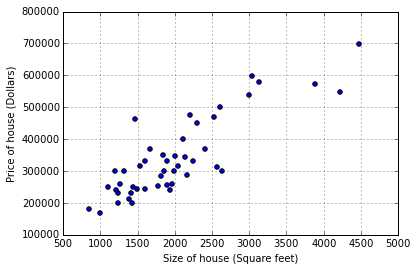

In [25]:
plt.scatter(housingPricesData.iloc[:,0],housingPricesData.iloc[:,2])
plt.xlabel('Size of house (Square feet)')
plt.ylabel('Price of house (Dollars)')
plt.grid(True)
plt.show()

### Plot 2: Number of bedrooms vs. Price of house

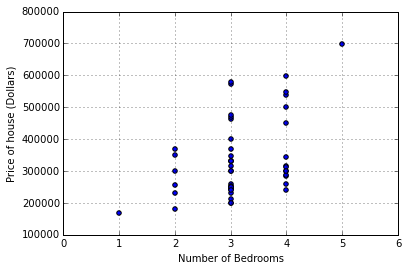

In [52]:
plt.scatter(housingPricesData.iloc[:,1],housingPricesData.iloc[:,2])
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price of house (Dollars)')
plt.grid(True)
plt.show()

## 2. Linear Regression with one variable/feature


#### 1.   X = training features matrix 
#### 2.   y = training labels vector
#### 3.   Theta = parameters vector

Goal: Find theta parameters vector using Normal Equation Method on Least Squares Regression

For this experiment, lets consider only one feature house_size to predict the price of house. 

Step 1: Create a function called normalEquation() that takes in X feature matrix and y label vector and returns a parameter vector.

![normal-equation](http://github.com/gdtm86/fts-summit-2015/blob/master/images/normal-Equation.png)


In [53]:
def normalEquation(X,y):
    theta = (np.linalg.inv(np.dot(np.transpose(X),X))).dot(np.dot(np.transpose(X),y))
    return theta

### Create training features vector and training lables vectos

1. Create feature vector
2. Create labels vector

In [54]:
X = housingPricesData.iloc[:,[0]]
y = housingPricesData.iloc[:,[2]]

In [55]:
X.shape

(47, 1)

In [56]:
y.shape

(47, 1)

### Add the extra feature to the feature vector

1. Add ones column to the X vector and name it as Xnew

In [57]:
ones = np.ones((47,1))
Xnew = np.concatenate((ones,X),axis=1)

In [58]:
Xnew.shape

(47, 2)

In [59]:
Xnew

array([[  1.00000000e+00,   2.10400000e+03],
       [  1.00000000e+00,   1.60000000e+03],
       [  1.00000000e+00,   2.40000000e+03],
       [  1.00000000e+00,   1.41600000e+03],
       [  1.00000000e+00,   3.00000000e+03],
       [  1.00000000e+00,   1.98500000e+03],
       [  1.00000000e+00,   1.53400000e+03],
       [  1.00000000e+00,   1.42700000e+03],
       [  1.00000000e+00,   1.38000000e+03],
       [  1.00000000e+00,   1.49400000e+03],
       [  1.00000000e+00,   1.94000000e+03],
       [  1.00000000e+00,   2.00000000e+03],
       [  1.00000000e+00,   1.89000000e+03],
       [  1.00000000e+00,   4.47800000e+03],
       [  1.00000000e+00,   1.26800000e+03],
       [  1.00000000e+00,   2.30000000e+03],
       [  1.00000000e+00,   1.32000000e+03],
       [  1.00000000e+00,   1.23600000e+03],
       [  1.00000000e+00,   2.60900000e+03],
       [  1.00000000e+00,   3.03100000e+03],
       [  1.00000000e+00,   1.76700000e+03],
       [  1.00000000e+00,   1.88800000e+03],
       [  

### Run normalEquation by passing new training matrix and labels vector

### This will retun the Theta vector

In [60]:
Theta = normalEquation(Xnew,y)

In [61]:
Theta

array([[ 71270.49244873],
       [   134.52528772]])

### Verify the results with Scikit-learn results

In [62]:
from sklearn import cross_validation
from sklearn import datasets, linear_model

In [63]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [64]:
regr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [65]:
print regr.intercept_
print regr.coef_

[ 71270.49244873]
[[ 134.52528772]]


### Split the data into training and test datasets

In [66]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.20, random_state=10)

In [67]:
X_train.shape

(37, 1)

In [68]:
y_train.shape

(37, 1)

In [69]:
X_test.shape

(10, 1)

In [70]:
y_test.shape

(10, 1)

### Run Linear Regression and evaluate the model

1) Calculate the RMSE

In [71]:
model1 = linear_model.LinearRegression()
model1.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [72]:
import math
RMSE = math.sqrt(np.mean((model1.predict(X_test) - y_test) ** 2))

In [73]:
print RMSE

54573.8179417


## 3. Linear Regression with multiple variables/features


#### 1.   X = training features matrix 
#### 2.   y = training labels vector
#### 3.   Theta = parameters vector

Goal: Find theta parameters vector using Normal Equation Method on Least Squares Regression

For this experiment, lets consider two features house_size and number_of_bedrooms to predict the price of house. 

In [76]:
X = housingPricesData.iloc[:,[0,1]]
y = housingPricesData.iloc[:,[2]]

In [77]:
X.shape

(47, 2)

In [78]:
y.shape

(47, 1)

### Add the extra feature to the feature vector

1. Add ones column to the X vector and name it as Xnew

In [80]:
ones = np.ones((47,1))
Xnew = np.concatenate((ones,X),axis=1)

In [81]:
Xnew.shape

(47, 3)

In [82]:
Xnew

array([[  1.00000000e+00,   2.10400000e+03,   3.00000000e+00],
       [  1.00000000e+00,   1.60000000e+03,   3.00000000e+00],
       [  1.00000000e+00,   2.40000000e+03,   3.00000000e+00],
       [  1.00000000e+00,   1.41600000e+03,   2.00000000e+00],
       [  1.00000000e+00,   3.00000000e+03,   4.00000000e+00],
       [  1.00000000e+00,   1.98500000e+03,   4.00000000e+00],
       [  1.00000000e+00,   1.53400000e+03,   3.00000000e+00],
       [  1.00000000e+00,   1.42700000e+03,   3.00000000e+00],
       [  1.00000000e+00,   1.38000000e+03,   3.00000000e+00],
       [  1.00000000e+00,   1.49400000e+03,   3.00000000e+00],
       [  1.00000000e+00,   1.94000000e+03,   4.00000000e+00],
       [  1.00000000e+00,   2.00000000e+03,   3.00000000e+00],
       [  1.00000000e+00,   1.89000000e+03,   3.00000000e+00],
       [  1.00000000e+00,   4.47800000e+03,   5.00000000e+00],
       [  1.00000000e+00,   1.26800000e+03,   3.00000000e+00],
       [  1.00000000e+00,   2.30000000e+03,   4.0000000

### Run normalEquation by passing new training matrix and labels vector

### This will retun the Theta vector

In [83]:
Theta = normalEquation(Xnew,y)

In [84]:
Theta

array([[ 89597.9095428 ],
       [   139.21067402],
       [ -8738.01911233]])

### Verify the results with Scikit-learn results

In [87]:
regr_multipleFeatures = linear_model.LinearRegression()

In [88]:
regr_multipleFeatures.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [119]:
print regr_multipleFeatures.intercept_
print regr_multipleFeatures.coef_

[ 89597.9095428]
[[  139.21067402 -8738.01911233]]


### Split the data into training and test datasets

In [120]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.20, random_state=11)

In [121]:
X_train.shape

(37, 2)

In [122]:
y_train.shape

(37, 1)

In [123]:
X_test.shape

(10, 2)

In [124]:
y_test.shape

(10, 1)

### Run Linear Regression and evaluate the model

1) Calculate the RMSE

In [100]:
model2 = linear_model.LinearRegression()
model2.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [101]:
import math
RMSE = math.sqrt(np.mean((model2.predict(X_test) - y_test) ** 2))
print RMSE

51309.0705831


### Plot actual values vs predicted values

1. Create the y_predicted vector

In [102]:
y_predicted = model2.predict(X_test)

In [115]:
X_test['house_size']

2     2400
35    1437
34    1811
22    1604
8     1380
14    1268
45    1852
40    1664
30    1839
42    2567
Name: house_size, dtype: int64

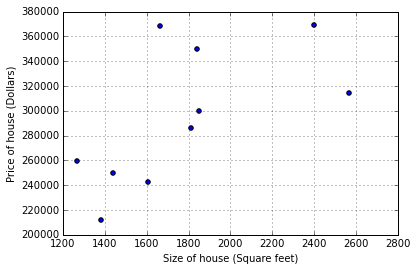

In [116]:
plt.scatter(X_test['house_size'],y_test)
plt.xlabel('Size of house (Square feet)')
plt.ylabel('Price of house (Dollars)')
plt.grid(True)
plt.show()

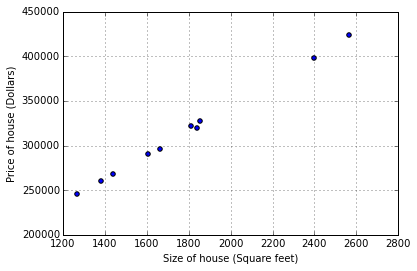

In [127]:
plt.scatter(X_test['house_size'],y_predicted)
plt.xlabel('Size of house (Square feet)')
plt.ylabel('Price of house (Dollars)')
plt.grid(True)
plt.show()

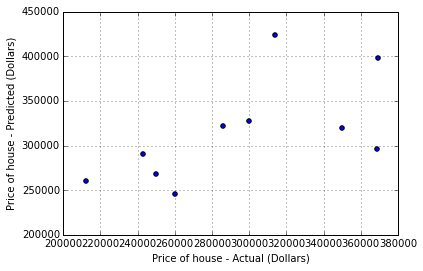

In [128]:
plt.scatter(y_test,y_predicted)
plt.xlabel('Price of house - Actual (Dollars)')
plt.ylabel('Price of house - Predicted (Dollars)')
plt.grid(True)
plt.show()